# Random Forest Project

In [8]:
from dotenv import load_dotenv
import os, sys
import pandas as pd
import numpy as np
import time
import datetime as dt
from sqlmodel import Session
from typing import Tuple, List
from joblib import Memory
import gc

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))  
from services.house import HouseService
from models.user_input import UserInput
from models.house import House
from db import engine, db_session

load_dotenv()

db_url = os.getenv("DATABASE_URL")

In [9]:
mem = Memory(location="./cache", verbose=0)

@mem.cache
def fetch_house_df():
    with Session(engine) as s:
        return HouseService(s).get_house_data_df()

@mem.cache
def fetch_housing2_df():
    with Session(engine) as s:
        return HouseService(s).get_housing_data2_df()

t0 = dt.datetime.now()
house_data_df   = fetch_house_df()      # first run → SQL; next → cache
housing_data_df = fetch_housing2_df()
with Session(engine) as s:
    house_svc = HouseService(s)
print(f"Loaded in {(dt.datetime.now()-t0).total_seconds():.2f}s")
print("Via cached fetch:")
print(house_data_df.head(), housing_data_df.head(), sep="\n")

Loaded in 0.15s
Via cached fetch:
     area  cost_of_living  quality_of_life_education_and_health     price  \
0   925.0        66898.06                                    43  135000.0   
1   800.0        66898.06                                    43  119900.0   
2  1580.0        66898.06                                    43   60000.0   
3  1120.0        66898.06                                    43   55000.0   
4  1354.0        66898.06                                    43  150000.0   

   avg_c2i  quality_of_life_safety     id temperature  mean_income  \
0   108.45                      22  29119         Hot      47257.0   
1   108.45                      22  29120         Hot      47257.0   
2   108.45                      22  29121         Hot      47257.0   
3   108.45                      22  29122         Hot      47257.0   
4   108.45                      22  29123         Hot      47257.0   

   population  ...  crime_rate quality_of_life_quality  state  unemployment  \
0  

# User Inputs to the Model 
### For the population question: 
#### House dataset
- Small: 0 - 672508, 
- Medium: 672509 - 1452726, 
- Large: >= 1452727 

#### Housing Data 2 dataset
- Small: 0 - 25556, 
- Medium: 25557 - 115264, 
- Large: >= 115265 

### For all other questions, we will attempt to matchmake you to answers close to yours with pinpoint accuracy

In [10]:
# Define user inputs here
user_desired_home_price = input("What is your target home price? (e.g. 345000)")
user_income = input("What is your income? (e.g. 123000)")
user_beds = input("How many bedrooms would you like your home to have? (e.g. 3)")
user_baths = input("How many bathrooms would you like your home to have? (e.g. 2)")
user_area = input("Do you have an ideal square footage in mind? (e.g. 1350)")
user_population = input("What size of a city would you like to live in? (e.g. Small, Medium, Large)")

# Transforming Database Tables Into Dataframes


# Now we need to create the Random Forest Model, Input the 2 dataframes, and then output results

In [11]:
# Group the populations by quantile and save to CSVs
house_data_df["population_category"] = house_svc.categorize_pop_by_quantile(house_data_df["population"])
housing_data_df["population_category"] = house_svc.categorize_pop_by_quantile(housing_data_df["population"])
house_svc.save_house_data_to_csvs(house_data=house_data_df, housing_data=housing_data_df)

House data saved to ../data/house_data.csv
House data saved to ../data/housing_data2.csv


In [12]:
user_input = house_svc.fill_user_defaults(df=house_data_df,u=UserInput(
    desired_home_price=int(user_desired_home_price) if user_desired_home_price else None,
    income=int(user_income) if user_income else None,
    bedroom=int(user_beds) if user_beds else None,
    bathroom=int(user_baths) if user_baths else None,
    area=int(user_area) if user_area else None,
    population=user_population.strip().lower() if user_population else None
    ), mapping={
    "desired_home_price": "price",
    "income"            : "mean_income",
    "bedroom"           : "bedroom",
    "bathroom"          : "bathroom",
    "area"              : "area",
    "population"        : "population_category",
})

WEIGHTS = dict(
    # Listing-level matches
    price=.20, income=.20, beds=.10, baths=.10, area=.10, pop=.10,
    # Economics / environment (works for both CSVs)
    cost=.15, crime=.1, waterquality=.05, aqi=.05, unemployed=.05,
    # Quality-of-life sub-scores (exist only in house_data)
    qol_total=.05, qol_aff=.05, qol_econ=.05, qol_ed=.05, qol_safe=.05,
)

# ========= builder that works for HOUSE_DATA.CSV =========
def target_house(df: pd.DataFrame, user: UserInput) -> pd.Series:
    rel = lambda col,val: 1 - np.minimum(abs(df[col]-val)/max(val,1), 1)
    z   = lambda col: (df[col]-df[col].min())/(df[col].max()-df[col].min())

    return (
        WEIGHTS['price'] * rel('price', user.desired_home_price) +
        WEIGHTS['income'] * rel('mean_income', user.income) +
        WEIGHTS['beds']  * rel('bedroom',      user.bedroom) +
        WEIGHTS['baths'] * rel('bathroom',     user.bathroom) +
        WEIGHTS['area']  * rel('area',         user.area) +
        WEIGHTS['pop']   * (df['population'] == user.population).astype(float) +

        WEIGHTS['cost']  * (1 - z('cost_of_living')) +
        WEIGHTS['crime'] * (1 - z('crime_rate')) +
        WEIGHTS['aqi']   * z('aqi_good') +
        WEIGHTS['unemployed'] * (1 - z('unemployment')) +
        WEIGHTS['waterquality'] * (1 - z('water_quality_vpv')) +

        WEIGHTS['qol_total'] * z('quality_of_life_total_score') + 
        WEIGHTS['qol_aff'] * z('quality_of_life_affordability') + 
        WEIGHTS['qol_econ'] * z('quality_of_life_economy') +
        WEIGHTS['qol_ed'] * z('quality_of_life_education_and_health') +
        WEIGHTS['qol_safe'] * z('quality_of_life_safety')
    )

# ========= builder that works for HOUSing_DATA.CSV =========
def target_housing2(df: pd.DataFrame, user: UserInput = None) -> pd.Series:
    rel = lambda col,val: 1 - np.minimum(abs(df[col]-val)/max(val,1), 1)
    z = lambda col: (df[col]-df[col].min())/(df[col].max()-df[col].min())
    return (
        WEIGHTS['price'] * rel('price', user.desired_home_price) +
        WEIGHTS['income'] * rel('median_income', user.income) +
        WEIGHTS['beds']  * rel('bedroom', user.bedroom) +
        WEIGHTS['baths'] * rel('bathroom', user.bathroom) +
        WEIGHTS['area']  * rel('area', user.area) +
        WEIGHTS['pop']   * (df['population'] == user.population).astype(float) +
        
        WEIGHTS['cost']  * (1 - z('cost_of_living')) +
        WEIGHTS['crime'] * (1 - z('crime_rate')) +
        WEIGHTS['aqi']   * z('aqi_good') +
        WEIGHTS['unemployed'] * (1 - z('unemployment')) +
        WEIGHTS['waterquality'] * (1 - z('water_quality_vpv'))
        # listing-level & QoL weights are ignored here
    )

def train_rf_and_rank(df: pd.DataFrame,
                      user: UserInput,
                      target_builder,
                      test_frac: float = 0.8,
                      rng: int = 42,
                      n_estimators: int = 80,
                      max_depth: int = 12,
                      top_n: int = 5):
    """Return (pipeline, metrics_dict, topN_df)."""

    # -------------------------------------------------
    # 0)   build target column for THIS user
    # -------------------------------------------------
    df = df.copy()
    df['target'] = target_builder(df, user) 
    df = df.dropna(subset=['target']).reset_index(drop=True)
    X = df.drop(columns=['target'])
    y = df['target']

    # -------------------------------------------------
    # 1)   20 % train / 80 % test
    # -------------------------------------------------
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        train_size=1-test_frac,
        test_size=test_frac,
        random_state=rng
    )

    num_cols = X_tr.select_dtypes(include='number').columns.tolist()
    cat_cols = [c for c in X_tr.columns if c not in num_cols]

    num_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('sca', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=-1))
    ])
    pre = ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ])

    rf = Pipeline([
        ('pre', pre),
        ('rf',  RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    random_state=rng,
                    n_jobs=1)) # 1 core → low RAM
    ])

    rf.fit(X_tr, y_tr)

    # -------------------------------------------------
    # 2)   metrics on held-out set
    # -------------------------------------------------
    pred = rf.predict(X_te)
    metrics = dict(
        RMSE = mean_squared_error(y_te, pred),
        MAE  = mean_absolute_error(y_te, pred),
        MAPE = np.mean(np.abs((y_te - pred)/np.maximum(1e-12, y_te))),
        R2   = r2_score(y_te, pred)
    )

    # -------------------------------------------------
    # 3)   rank every city for THIS user
    # -------------------------------------------------
    df['rf_score'] = rf.predict(X)
    top = (df.groupby(['state','city'])['rf_score']
             .mean().reset_index()
             .sort_values('rf_score', ascending=False)
             .head(top_n))

    return rf, metrics, top

# Results

In [13]:
house_pipeline, house_loss, house_top5 = train_rf_and_rank(
    house_data_df, user_input, target_builder=target_house, test_frac=0.8, top_n=5)

print("House Data")
print("Loss / accuracy metrics on 80 % hold-out:")
for k,v in house_loss.items():
    print(f"{k:5}: {v:.4f}")
    
print("\n---------------------------------------------\n")
print("Top-5 recommended cities:")
print(house_top5)

housing_pipeline, housing_loss, housing_top5 = train_rf_and_rank(
    housing_data_df, user_input, target_builder=target_housing2, test_frac=0.8, top_n=5)

print("\n--------------------------------------------------------------------------------\n")
print("Housing Data")
print("Loss / accuracy metrics on 80 % hold-out:")
for k,v in housing_loss.items():
    print(f"{k:5}: {v:.4f}")
    
print("\n---------------------------------------------\n")
print("Top-5 recommended cities:")
print(housing_top5)


House Data
Loss / accuracy metrics on 80 % hold-out:
RMSE : 0.0001
MAE  : 0.0083
MAPE : 0.0114
R2   : 0.9695

---------------------------------------------

Top-5 recommended cities:
    state           city  rf_score
135    nv  winnemucca,nv  0.876806
117    nd   williston,nd  0.826252
132    nv         ely,nv  0.801621
17     ca      bishop,ca  0.793125
102    ms      tupelo,ms  0.787156

--------------------------------------------------------------------------------

Housing Data
Loss / accuracy metrics on 80 % hold-out:
RMSE : 0.0002
MAE  : 0.0102
MAPE : 0.0157
R2   : 0.9633

---------------------------------------------

Top-5 recommended cities:
     state         city  rf_score
6771    sd    ramona,sd  0.781279
5303    nd   lignite,nd  0.781175
2022    ia      hull,ia  0.780263
5268    nd   flasher,nd  0.780139
5418    ne  humphrey,ne  0.779729


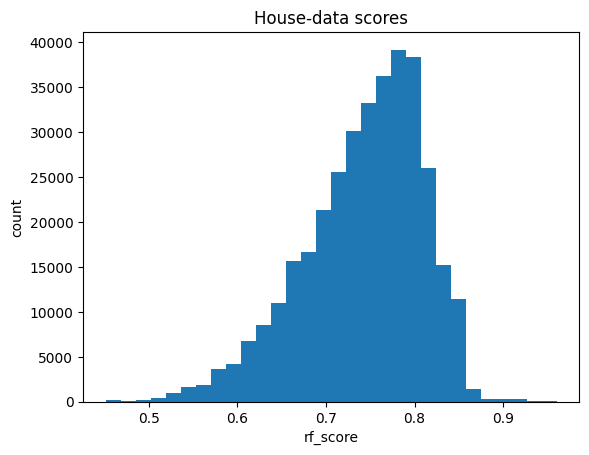

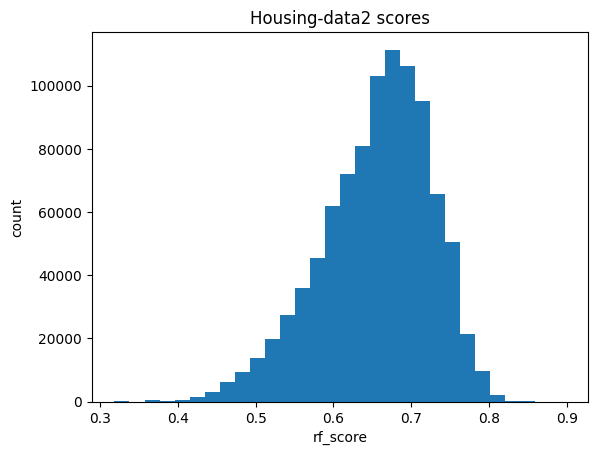

In [14]:
# give the model the full frame (minus target), not a pruned one
X_house_full = house_data_df.copy()        # it never had 'target'
house_scores = house_pipeline.predict(X_house_full)

plt.hist(house_scores, bins=30)
plt.xlabel('rf_score'); plt.ylabel('count'); plt.title('House-data scores')
plt.show()

# use *housing_pipeline* for housing_data_df
X_housing_full = housing_data_df.copy()
housing_scores = housing_pipeline.predict(X_housing_full)

plt.hist(housing_scores, bins=30)
plt.xlabel('rf_score'); plt.ylabel('count'); plt.title('Housing-data2 scores')
plt.show()
